In [4]:
from __future__ import division
import time, os, gc
import numpy as np
import pandas as pd
import scipy
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

# SEED = 24
# np.random.seed(SEED)
PATH = os.path.expanduser("~") + "/data/quora/"
print os.listdir(PATH)

['X_tfidf.svm', 'test_question1_porter_tfidf.pkl', 'train.csv', 'features', 'train_interaction.pkl', 'glove.840B.300d.zip', 'test_question2_tfidf.pkl', 'quora_duplicate_questions.tsv', 'sample_submission.csv (1).zip', 'test_len.pkl', 'train_question2_porter_tfidf.pkl', 'train_porter_jaccard.pkl', 'train_len.pkl', 'nltk_data', 'test_jaccard.pkl', 'train_porter.csv', 'GoogleNews-vectors-negative300.bin.gz', 'X_train_tfidf.svm', 'X_test_tfidf.svm', 'train_question1_porter_tfidf.pkl', 'clicks_test.csv.zip', 'test_porter_jaccard.pkl', 'train_check.csv', 'X_t_tfidf.svm', 'glove.840B.300d.txt', 'train_porter_interaction.pkl', 'test_interaction.pkl', 'train_question1_tfidf.pkl', 'sample_submission.csv', 'train_question2_tfidf.pkl', 'test_porter_interaction.pkl', 'test_porter.csv', 'train_jaccard.pkl', 'test_question2_porter_tfidf.pkl', 'test_question1_tfidf.pkl', 'submission', 'train.csv.zip', 'test.csv']


In [230]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation

stop_words = stopwords.words('english')
# stop_words = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
#               'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
#               'Is','If','While','This']
text1 = '''When do you $3.44k utilization "&" insteading of "シ"?'''
text = ''.join([c for c in text1 if c not in punctuation])
print text

text = text.split()
text = [w for w in text if not w in stop_words]
text = " ".join(text)
print text

text = text.split()
stemmer = SnowballStemmer('english')
stemmed_words = [stemmer.stem(word.decode("utf-8")) for word in text]
text = " ".join(stemmed_words)

print text

When do you 344k utilization  insteading of シ
When 344k utilization insteading シ
when 344k util instead シ


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:21: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [123]:
def isEnglish(s):
    try:
        s.decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

train['en1'] = train['question1'].astype(str).apply(lambda x: isEnglish(x))
train['en2'] = train['question2'].astype(str).apply(lambda x: isEnglish(x))
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,jp1,jp2,en1,en2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0,0,True,True
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0,0,True,True
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0,0,True,True
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0,0,True,True
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0,0,True,True


In [19]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    return - WORDS[word] 

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

correction('adverve')

'adverse'

In [8]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
import distance
from nltk.corpus import stopwords
import nltk
SEED = 2048
np.random.seed(SEED)
PATH = os.path.expanduser("~") + "/data/quora/"

train = pd.read_csv(PATH+"train_porter.csv")#, nrows=5000).astype(str)
test = pd.read_csv(PATH+"test_porter.csv")#, nrows=5000).astype(str)

def str_abs_diff_len(str1, str2):
    try: a = abs(len(str1)-len(str2))
    except: 
        print str1, str2
        a = 0
    return a

def str_len(str1):
    return len(str(str1))

def char_len(str1):
    str1_list = set(str(str1).replace(' ',''))
    return len(str1_list)

def word_len(str1):
    try:
        str1_list = str1.split(' ')
    except:
        print str1
        str1_list = '1'
    return len(str1_list)

stop_words = stopwords.words('english')
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stop_words:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stop_words:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    return (len(shared_words_in_q1) + len(shared_words_in_q2))*1.0/(len(q1words) + len(q2words))

print('Generate len')
feats = []

# train['abs_diff_len'] = train.apply(lambda x:str_abs_diff_len(x['question1'],x['question2']),axis=1)
# test['abs_diff_len']= test.apply(lambda x:str_abs_diff_len(x['question1'],x['question2']),axis=1)
# feats.append('abs_diff_len')

# train['R']=train.apply(word_match_share, axis=1, raw=True)
# test['R']=test.apply(word_match_share, axis=1, raw=True)
# feats.append('R')

# train['common_words'] = train.apply(lambda x: len(set(str(x['question1'])
#         .lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
# test['common_words'] = test.apply(lambda x: len(set(str(x['question1'])
#         .lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
# feats.append('common_words')

for c in ['question1','question2']:
    train['%s_char_len'%c] = train[c].apply(lambda x:char_len(x))
    test['%s_char_len'%c] = test[c].apply(lambda x:char_len(x))
    feats.append('%s_char_len'%c)

    train['%s_str_len'%c] = train[c].apply(lambda x:str_len(x))
    test['%s_str_len'%c] = test[c].apply(lambda x:str_len(x))
    feats.append('%s_str_len'%c)
    
    train['%s_word_len'%c] = train[c].apply(lambda x:word_len(x))
    test['%s_word_len'%c] = test[c].apply(lambda x:word_len(x))
    feats.append('%s_word_len'%c)

pd.to_pickle(train[feats].values,PATH+"train_len.pkl")
pd.to_pickle(test[feats].values,PATH+"test_len.pkl")


Generate len
nan
nan
nan
nan
nan
nan
nan
nan


In [10]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 20 11:23:59 2017

@author: mariosm
"""
import os
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix,hstack
from sklearn.feature_extraction import text
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy import sparse as ssp
from sklearn.datasets import dump_svmlight_file,load_svmlight_file
from sklearn.utils import resample,shuffle
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import distance
stop_words = stopwords.words('english')
    
#stops = set(stopwords.words("english"))
stops = set(["http","www","img","border","home","body","a","about","above","after","again","against","all","am","an",
"and","any","are","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can't",
"cannot","could","couldn't","did","didn't","do","does","doesn't","doing","don't","down","during","each","few","for","from",
"further","had","hadn't","has","hasn't","have","haven't","having","he","he'd","he'll","he's","her","here","here's","hers",
"herself","him","himself","his","how","how's","i","i'd","i'll","i'm","i've","if","in","into","is","isn't","it","it's","its",
"itself","let's","me","more","most","mustn't","my","myself","no","nor","not","of","off","on","once","only","or","other","ought",
"our","ours","ourselves","out","over","own","same","shan't","she","she'd","she'll","she's","should","shouldn't","so","some","such",
"than","that","that's","the","their","theirs","them","themselves","then","there","there's","these","they","they'd","they'll","they're",
"they've","this","those","through","to","too","under","until","up","very","was","wasn't","we","we'd","we'll","we're","we've","were",
"weren't","what","what's","when","when's""where","where's","which","while","who","who's","whom","why","why's","with","won't","would",
"wouldn't","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves" ])
porter = PorterStemmer()
snowball = SnowballStemmer('english')

weights={}

def fromsparsetofile(filename, array, deli1=" ", deli2=":",ytarget=None):    
    zsparse=csr_matrix(array)
    indptr = zsparse.indptr
    indices = zsparse.indices
    data = zsparse.data
    print(" data lenth %d" % (len(data)))
    print(" indices lenth %d" % (len(indices)))    
    print(" indptr lenth %d" % (len(indptr)))
    
    f=open(filename,"w")
    counter_row=0
    for b in range(0,len(indptr)-1):
        #if there is a target, print it else , print nothing
        if ytarget!=None:
             f.write(str(ytarget[b]) + deli1)     
             
        for k in range(indptr[b],indptr[b+1]):
            if (k==indptr[b]):
                if np.isnan(data[k]):
                    f.write("%d%s%f" % (indices[k],deli2,-1))
                else :
                    f.write("%d%s%f" % (indices[k],deli2,data[k]))                    
            else :
                if np.isnan(data[k]):
                     f.write("%s%d%s%f" % (deli1,indices[k],deli2,-1))  
                else :
                    f.write("%s%d%s%f" % (deli1,indices[k],deli2,data[k]))
        f.write("\n")
        counter_row+=1
        if counter_row%10000==0:    
            print(" row : %d " % (counter_row))    
    f.close()  
    


# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=5000.0, min_count=2.0):
    if count < min_count:
        return 0.0
    else:
        return 1.0 / (count + eps)


def word_shares(row,wei,stop):
    q1 = set(str(row['question1']).lower().split())
    q1words = q1.difference(stop)
    if len(q1words) == 0:
        return '0:0:0:0:0'

    q2 = set(str(row['question2']).lower().split())
    q2words = q2.difference(stop)
    if len(q2words) == 0:
        return '0:0:0:0:0'

    q1stops = q1.intersection(stop)
    q2stops = q2.intersection(stop)

    shared_words = q1words.intersection(q2words)
    #print(len(shared_words))
    shared_weights = [wei.get(w, 0) for w in shared_words]
    total_weights = [wei.get(w, 0) for w in q1words] + [wei.get(w, 0) for w in q2words]

    R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
    R2 = float(len(shared_words)) / (float(len(q1words)) + float(len(q2words))) #count share
    R31 = float(len(q1stops)) / float(len(q1words)) #stops in q1
    R32 = float(len(q2stops)) / float(len(q2words)) #stops in q2
    return '{}:{}:{}:{}:{}'.format(R1, R2, float(len(shared_words)), R31, R32)

def stem_str(x,stemmer=SnowballStemmer('english')):
        x = text.re.sub("[^a-zA-Z0-9]"," ", x)
        x = (" ").join([stemmer.stem(z) for z in x.split(" ")])
        x = " ".join(x.split())
        return x
    
def calc_set_intersection(text_a, text_b):
    a = set(text_a.split())
    b = set(text_b.split())
    return len(a.intersection(b)) *1.0 / len(a)

def str_abs_diff_len(str1, str2):
    return abs(len(str1)-len(str2))

def str_len(str1):
    return len(str(str1))

def char_len(str1):
    str1_list = set(str(str1).replace(' ',''))
    return len(str1_list)

def word_len(str1):
    str1_list = str1.split(' ')
    return len(str1_list)

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stop_words:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stop_words:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))*1.0/(len(q1words) + len(q2words))
    return R

def str_jaccard(str1, str2):


    str1_list = str1.split(" ")
    str2_list = str2.split(" ")
    res = distance.jaccard(str1_list, str2_list)
    return res

# shortest alignment
def str_levenshtein_1(str1, str2):


    #str1_list = str1.split(' ')
    #str2_list = str2.split(' ')
    res = distance.nlevenshtein(str1, str2,method=1)
    return res

# longest alignment
def str_levenshtein_2(str1, str2):

    #str1_list = str1.split(' ')
    #str2_list = str2.split(' ')
    res = distance.nlevenshtein(str1, str2,method=2)
    return res

def str_sorensen(str1, str2):

    str1_list = str1.split(' ')
    str2_list = str2.split(' ')
    res = distance.sorensen(str1_list, str2_list)
    return res



def main():

    path="" # set your input folder here
   
  
    ######## from here on starts qqgeogor example from (https://www.kaggle.com/)#######
    #https://github.com/qqgeogor/kaggle_quora_benchmark
    
    
     ################### generate_stem .py################## 
    seed = 1024
    np.random.seed(seed)
    path = os.path.expanduser("~") + "/data/quora/"
    #re load to avoid errors. 
    
    train = pd.read_csv(path+"train.csv", nrows=250000)
    test = pd.read_csv(path+"test.csv", nrows=250000)

    print('Generate porter')
    train['question1_porter'] = train['question1'].astype(str).apply(lambda x:stem_str(x.lower(),snowball))
    test['question1_porter'] = test['question1'].astype(str).apply(lambda x:stem_str(x.lower(),snowball))
    
    train['question2_porter'] = train['question2'].astype(str).apply(lambda x:stem_str(x.lower(),snowball))
    test['question2_porter'] = test['question2'].astype(str).apply(lambda x:stem_str(x.lower(),snowball))
    
    train.to_csv(path+'train_porter.csv')
    test.to_csv(path+'test_porter.csv')
    

    ###################### generate_interaction.py ################    
    
    train = pd.read_csv(path+"train_porter.csv")
    test = pd.read_csv(path+"test_porter.csv")
    test['is_duplicated']=[-1]*test.shape[0]
    
    print('Generate intersection')
    train_interaction = train.astype(str).apply(lambda x:calc_set_intersection(x['question1'],x['question2']),axis=1)
    test_interaction = test.astype(str).apply(lambda x:calc_set_intersection(x['question1'],x['question2']),axis=1)
    pd.to_pickle(train_interaction,path+"train_interaction.pkl")
    pd.to_pickle(test_interaction,path+"test_interaction.pkl")
    
    print('Generate porter intersection')
    train_porter_interaction = train.astype(str).apply(lambda x:calc_set_intersection(x['question1_porter'],x['question2_porter']),axis=1)
    test_porter_interaction = test.astype(str).apply(lambda x:calc_set_intersection(x['question1_porter'],x['question2_porter']),axis=1)
    
    pd.to_pickle(train_porter_interaction,path+"train_porter_interaction.pkl")
    pd.to_pickle(test_porter_interaction,path+"test_porter_interaction.pkl")  
    
    ###################### generate_tfidf.py ################  

        
    ft = ['question1','question2','question1_porter','question2_porter']
    train = pd.read_csv(path+"train_porter.csv")[ft]
    test = pd.read_csv(path+"test_porter.csv")[ft]
    # test['is_duplicated']=[-1]*test.shape[0]
    
    data_all = pd.concat([train,test])
    print data_all
    
    max_features = None
    ngram_range = (1,2)
    min_df = 3
    print('Generate tfidf')
    feats= ['question1','question2']
    vect_orig = TfidfVectorizer(max_features=max_features,ngram_range=ngram_range, min_df=min_df)
    
    corpus = []
    for f in feats:
        data_all[f] = data_all[f].astype(str)
        corpus+=data_all[f].values.tolist()
    
    vect_orig.fit(corpus)
    
    for f in feats:
        tfidfs = vect_orig.transform(data_all[f].values.tolist())
        train_tfidf = tfidfs[:train.shape[0]]
        test_tfidf = tfidfs[train.shape[0]:]
        pd.to_pickle(train_tfidf,path+'train_%s_tfidf.pkl'%f)
        pd.to_pickle(test_tfidf,path+'test_%s_tfidf.pkl'%f)
    
    
    print('Generate porter tfidf')
    feats= ['question1_porter','question2_porter']
    vect_orig = TfidfVectorizer(max_features=max_features,ngram_range=ngram_range, min_df=min_df)
    
    corpus = []
    for f in feats:
        data_all[f] = data_all[f].astype(str)
        corpus+=data_all[f].values.tolist()
    
    vect_orig.fit(
        corpus
        )
    
    for f in feats:
        tfidfs = vect_orig.transform(data_all[f].values.tolist())
        train_tfidf = tfidfs[:train.shape[0]]
        test_tfidf = tfidfs[train.shape[0]:]
        pd.to_pickle(train_tfidf,path+'train_%s_tfidf.pkl'%f)
        pd.to_pickle(test_tfidf,path+'test_%s_tfidf.pkl'%f)    
        
        
    ##################### generate_len.py #########################
    
    train = pd.read_csv(path+"train_porter.csv").astype(str)
    test = pd.read_csv(path+"test_porter.csv").astype(str)
    
    print('Generate len')
    feats = []
    
    train['abs_diff_len'] = train.apply(lambda x:str_abs_diff_len(x['question1'],x['question2']),axis=1)
    test['abs_diff_len']= test.apply(lambda x:str_abs_diff_len(x['question1'],x['question2']),axis=1)
    feats.append('abs_diff_len')
    
    train['R']=train.apply(word_match_share, axis=1, raw=True)
    test['R']=test.apply(word_match_share, axis=1, raw=True)
    feats.append('R')
    
    train['common_words'] = train.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
    test['common_words'] = test.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
    feats.append('common_words')
    
    for c in ['question1','question2']:
        train['%s_char_len'%c] = train[c].apply(lambda x:char_len(x))
        test['%s_char_len'%c] = test[c].apply(lambda x:char_len(x))
        feats.append('%s_char_len'%c)
    
        train['%s_str_len'%c] = train[c].apply(lambda x:str_len(x))
        test['%s_str_len'%c] = test[c].apply(lambda x:str_len(x))
        feats.append('%s_str_len'%c)
        
        train['%s_word_len'%c] = train[c].apply(lambda x:word_len(x))
        test['%s_word_len'%c] = test[c].apply(lambda x:word_len(x))
        feats.append('%s_word_len'%c)
    

    pd.to_pickle(train[feats].values,path+"train_len.pkl")
    pd.to_pickle(test[feats].values,path+"test_len.pkl")       
    
    #########################generate_distance.py #################

    train = pd.read_csv(path+"train_porter.csv")
    test = pd.read_csv(path+"test_porter.csv")
    test['is_duplicated']=[-1]*test.shape[0]
    
    data_all = pd.concat([train,test])    
    
    print('Generate jaccard')
    train_jaccard = train.astype(str).apply(lambda x:str_jaccard(x['question1'],x['question2']),axis=1)
    test_jaccard = test.astype(str).apply(lambda x:str_jaccard(x['question1'],x['question2']),axis=1)
    pd.to_pickle(train_jaccard,path+"train_jaccard.pkl")
    pd.to_pickle(test_jaccard,path+"test_jaccard.pkl")
    
    print('Generate porter jaccard')
    train_porter_jaccard = train.astype(str).apply(lambda x:str_jaccard(x['question1_porter'],x['question2_porter']),axis=1)
    test_porter_jaccard = test.astype(str).apply(lambda x:str_jaccard(x['question1_porter'],x['question2_porter']),axis=1)
    
    pd.to_pickle(train_porter_jaccard,path+"train_porter_jaccard.pkl")
    pd.to_pickle(test_porter_jaccard,path+"test_porter_jaccard.pkl")  

#     path=""
    ###################  generate_svm_format_tfidf.py ################# 
    train = pd.read_csv(path+"train_porter.csv")    
    
    train_question1_tfidf = pd.read_pickle(path+'train_question1_tfidf.pkl')[:]
    test_question1_tfidf = pd.read_pickle(path+'test_question1_tfidf.pkl')[:]

    
    train_question2_tfidf = pd.read_pickle(path+'train_question2_tfidf.pkl')[:]
    test_question2_tfidf = pd.read_pickle(path+'test_question2_tfidf.pkl')[:]
 

    #train_question1_porter_tfidf = pd.read_pickle(path+'train_question1_porter_tfidf.pkl')[:]
    #test_question1_porter_tfidf = pd.read_pickle(path+'test_question1_porter_tfidf.pkl')[:]
    
    #train_question2_porter_tfidf = pd.read_pickle(path+'train_question2_porter_tfidf.pkl')[:]
    #test_question2_porter_tfidf = pd.read_pickle(path+'test_question2_porter_tfidf.pkl')[:]
    
    
    train_interaction = pd.read_pickle(path+'train_interaction.pkl')[:].reshape(-1,1)
    test_interaction = pd.read_pickle(path+'test_interaction.pkl')[:].reshape(-1,1)

    train_interaction=np.nan_to_num(train_interaction)
    test_interaction=np.nan_to_num(test_interaction)      

    
    train_porter_interaction = pd.read_pickle(path+'train_porter_interaction.pkl')[:].reshape(-1,1)
    test_porter_interaction = pd.read_pickle(path+'test_porter_interaction.pkl')[:].reshape(-1,1)


    train_porter_interaction=np.nan_to_num(train_porter_interaction)
    test_porter_interaction=np.nan_to_num(test_porter_interaction)
    
    
    train_jaccard = pd.read_pickle(path+'train_jaccard.pkl')[:].reshape(-1,1)
    test_jaccard = pd.read_pickle(path+'test_jaccard.pkl')[:].reshape(-1,1)


    train_jaccard=np.nan_to_num(train_jaccard)
    test_jaccard=np.nan_to_num(test_jaccard)
    
    train_porter_jaccard = pd.read_pickle(path+'train_porter_jaccard.pkl')[:].reshape(-1,1)
    test_porter_jaccard = pd.read_pickle(path+'test_porter_jaccard.pkl')[:].reshape(-1,1)


    train_jaccard=np.nan_to_num(train_jaccard)
    test_porter_jaccard=np.nan_to_num(test_porter_jaccard)
    
    train_len = pd.read_pickle(path+"train_len.pkl")
    test_len = pd.read_pickle(path+"test_len.pkl")
    
    train_len=np.nan_to_num(train_len)
    test_len=np.nan_to_num(test_len) 
    

    scaler = MinMaxScaler()
    scaler.fit(np.vstack([train_len,test_len]))
    train_len = scaler.transform(train_len)
    test_len =scaler.transform(test_len)
 
    
    
    X = ssp.hstack([
        train_question1_tfidf,
        train_question2_tfidf,
        train_interaction,
        train_porter_interaction,
        train_jaccard,
        train_porter_jaccard,
        train_len
        ]).tocsr()
    
    
    y = train['is_duplicate'].values[:]
    
    X_t = ssp.hstack([
        test_question1_tfidf,
        test_question2_tfidf,
        test_interaction,
        test_porter_interaction,
        test_jaccard,
        test_porter_jaccard,
        test_len
        ]).tocsr()
    
    
    print X.shape
    print X_t.shape
    
    fromsparsetofile(path + "x_tfidf.svm", X, deli1=" ", deli2=":",ytarget=y)
    del X
    fromsparsetofile(path + "x_t_tfidf.svm", X_t, deli1=" ", deli2=":",ytarget=None)
    del X_t

   
    

    
    print ("done!")      
    
                     
if __name__=="__main__":
    main()
  

Generate porter
Generate intersection
Generate porter intersection
                                                question1  \
0       What is the step by step guide to invest in sh...   
1       What is the story of Kohinoor (Koh-i-Noor) Dia...   
2       How can I increase the speed of my internet co...   
3       Why am I mentally very lonely? How can I solve...   
4       Which one dissolve in water quikly sugar, salt...   
5       Astrology: I am a Capricorn Sun Cap moon and c...   
6                                     Should I buy tiago?   
7                          How can I be a good geologist?   
8                         When do you use シ instead of し?   
9       Motorola (company): Can I hack my Charter Moto...   
10      Method to find separation of slits using fresn...   
11            How do I read and find my YouTube comments?   
12                   What can make Physics easy to learn?   
13            What was your first sexual experience like?   
14      What are t

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:145: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


Generate jaccard
Generate porter jaccard


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:148: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:371: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:372: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:378: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:379: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:386: FutureWarning:

(250000, 845903)
(250000, 845903)
 data lenth 12263345
 indices lenth 12263345
 indptr lenth 250001


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:58: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


 row : 10000 
 row : 20000 
 row : 30000 
 row : 40000 
 row : 50000 
 row : 60000 
 row : 70000 
 row : 80000 
 row : 90000 
 row : 100000 
 row : 110000 
 row : 120000 
 row : 130000 
 row : 140000 
 row : 150000 
 row : 160000 
 row : 170000 
 row : 180000 
 row : 190000 
 row : 200000 
 row : 210000 
 row : 220000 
 row : 230000 
 row : 240000 
 row : 250000 
 data lenth 11952534
 indices lenth 11952534
 indptr lenth 250001
 row : 10000 
 row : 20000 
 row : 30000 
 row : 40000 
 row : 50000 
 row : 60000 
 row : 70000 
 row : 80000 
 row : 90000 
 row : 100000 
 row : 110000 
 row : 120000 
 row : 130000 
 row : 140000 
 row : 150000 
 row : 160000 
 row : 170000 
 row : 180000 
 row : 190000 
 row : 200000 
 row : 210000 
 row : 220000 
 row : 230000 
 row : 240000 
 row : 250000 
done!


In [13]:
from sklearn.feature_extraction import text
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
SEED = 2048
np.random.seed(SEED)
PATH = os.path.expanduser("~") + "/data/quora/"

train = pd.read_csv(PATH + "train.csv", nrows=50000)
# test = pd.read_csv(PATH + "test.csv")#, nrows=5000)

def stem_str(x1,stemmer=SnowballStemmer('english')):
    try:
        x = text.re.sub("[^a-zA-Z0-9]"," ", x1)
        x = (" ").join([stemmer.stem(z) for z in x.split(" ")])
        x = " ".join(x.split())
    except: print x1, x
    return x

porter = PorterStemmer()
snowball = SnowballStemmer('english')

# print ('Generate porter')
# train['question1_porter'] = train['question1'].astype(str).apply(lambda x: stem_str(x.lower(),snowball))
# test['question1_porter'] = test['question1'].astype(str).apply(lambda x: stem_str(x.lower(),porter))
train['question2_porter'] = train['question2'].astype(str).apply(lambda x: stem_str(x.lower(),porter))
# test['question2_porter'] = test['question2'].astype(str).apply(lambda x: stem_str(x.lower(),porter))

x= 'do banks in dubai offer credit cards on an aed 4000 salary'
x = (" ").join([snowball.stem(z) for z in x.split(" ")])
x = " ".join(x.split())
print x

do banks in dubai offer credit cards on an aed 4000 salary? do banks in dubai offer credit cards on an aed 4000 salary 


In [5]:
df= pd.read_csv(PATH+'train.csv')
pos = df[df.is_duplicate==1]

import networkx as nx

g = nx.Graph()
g.add_nodes_from(pos.question1)
g.add_nodes_from(pos.question2)
edges = list(pos[['question1','question2']].to_records(index=False))
g.add_edges_from(edges)
len(set(pos.question1) | set(pos.question2)), g.number_of_nodes()

(149596, 149596)

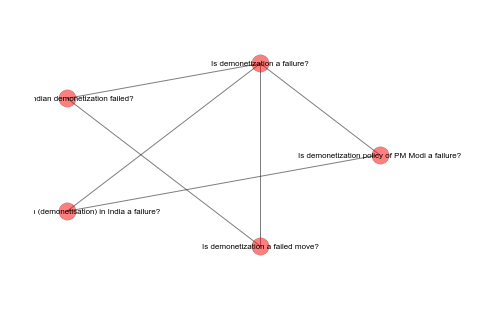

In [14]:
# with block handles a deprecation warning that occurs inside nx.draw_networkx
import warnings
cc = filter(lambda x : (len(x) > 3), 
            nx.connected_component_subgraphs(g))
# g1 = next(cc)
# g1.nodes()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    nx.draw_circular(cc[2], with_labels=True, alpha=0.5, font_size=8)
    plt.show()


In [19]:
l = []
for i in cc[0]:
    l.append(i)
l

['How can I be less self conscious?',
 'How to be less self-conscious?',
 'How can I become less self conscious and insecure?',
 'How do I become less conscious of myself around other people?',
 'How can be less self-conscious?']

In [1]:
"""
Detecting duplicate quora questions
feature engineering
@author: Abhishek Thakur
"""

import cPickle
import pandas as pd
import numpy as np
import gensim
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from nltk import word_tokenize
stop_words = stopwords.words('english')


def wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return model.wmdistance(s1, s2)


def norm_wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return norm_model.wmdistance(s1, s2)


def sent2vec(s):
    words = str(s).lower().decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())


data = pd.read_csv('data/quora_duplicate_questions.tsv', sep='\t')
data = data.drop(['id', 'qid1', 'qid2'], axis=1)


data['len_q1'] = data.question1.apply(lambda x: len(str(x)))
data['len_q2'] = data.question2.apply(lambda x: len(str(x)))
data['diff_len'] = data.len_q1 - data.len_q2
data['len_char_q1'] = data.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
data['len_char_q2'] = data.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
data['len_word_q1'] = data.question1.apply(lambda x: len(str(x).split()))
data['len_word_q2'] = data.question2.apply(lambda x: len(str(x).split()))
data['common_words'] = data.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
data['fuzz_qratio'] = data.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_WRatio'] = data.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_partial_ratio'] = data.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_partial_token_set_ratio'] = data.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_partial_token_sort_ratio'] = data.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_token_set_ratio'] = data.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_token_sort_ratio'] = data.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)


model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)
data['wmd'] = data.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)


norm_model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)
norm_model.init_sims(replace=True)
data['norm_wmd'] = data.apply(lambda x: norm_wmd(x['question1'], x['question2']), axis=1)

question1_vectors = np.zeros((data.shape[0], 300))
error_count = 0

for i, q in tqdm(enumerate(data.question1.values)):
    question1_vectors[i, :] = sent2vec(q)

question2_vectors  = np.zeros((data.shape[0], 300))
for i, q in tqdm(enumerate(data.question2.values)):
    question2_vectors[i, :] = sent2vec(q)

data['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]

data['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]

data['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]

data['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]

data['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]

data['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]

data['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]

data['skew_q1vec'] = [skew(x) for x in np.nan_to_num(question1_vectors)]
data['skew_q2vec'] = [skew(x) for x in np.nan_to_num(question2_vectors)]
data['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors)]
data['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors)]

cPickle.dump(question1_vectors, open('data/q1_w2v.pkl', 'wb'), -1)
cPickle.dump(question2_vectors, open('data/q2_w2v.pkl', 'wb'), -1)

data.to_csv('data/quora_features.csv', index=False)


ImportError: No module named gensim

In [ ]:
all_ques_df["num_of_words"] = all_ques_df["questions"].apply(lambda x : len(str(x).split()))
all_ques_df["num_of_chars"] = all_ques_df["questions"].apply(lambda x : len(str(x)))


In [ ]:
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
eng_stopwords = set(stopwords.words('english'))

def get_unigrams(que):
    return [word for word in word_tokenize(que.lower()) if word not in eng_stopwords]

def get_common_unigrams(row):
    # q1 & q2
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])))

def get_common_unigram_ratio(row):
    # q1 | q2
    return float(row["unigrams_common_count"]) / max( len(set(row["unigrams_ques1"]
                                            ).union(set(row["unigrams_ques2"]))), 1)

df["unigrams_ques1"] = df['question1'].apply(lambda x: get_unigrams(str(x)))
df["unigrams_ques2"] = df['question2'].apply(lambda x: get_unigrams(str(x)))
df["unigrams_common_count"] = df.apply(lambda row: get_common_unigrams(row),axis=1)
df["unigrams_common_ratio"] = df.apply(lambda row: get_common_unigram_ratio(row), axis=1)

def get_bigrams(que):
    return [i for i in ngrams(que, 2)]

def get_common_bigrams(row):
    return len( set(row["bigrams_ques1"]).intersection(set(row["bigrams_ques2"])) )

def get_common_bigram_ratio(row):
    return float(row["bigrams_common_count"]) / max(len( set(row["bigrams_ques1"]
                                            ).union(set(row["bigrams_ques2"]))), 1)

df["bigrams_ques1"] = df["unigrams_ques1"].apply(lambda x: get_bigrams(x))
df["bigrams_ques2"] = df["unigrams_ques2"].apply(lambda x: get_bigrams(x)) 
df["bigrams_common_count"] = df.apply(lambda row: get_common_bigrams(row),axis=1)
df["bigrams_common_ratio"] = df.apply(lambda row: get_common_bigram_ratio(row), axis=1)

In [ ]:
def feature_extraction(row):
    que1 = str(row['question1'])
    que2 = str(row['question2'])
    out_list = []
    # get unigram features #
    unigrams_que1 = [word for word in que1.lower().split() if word not in eng_stopwords]
    unigrams_que2 = [word for word in que2.lower().split() if word not in eng_stopwords]
    common_unigrams_len = len(set(unigrams_que1).intersection(set(unigrams_que2)))
    common_unigrams_ratio = float(common_unigrams_len) / max(len(set(unigrams_que1).union(set(unigrams_que2))),1)
    out_list.extend([common_unigrams_len, common_unigrams_ratio])

    # get bigram features #
    bigrams_que1 = [i for i in ngrams(unigrams_que1, 2)]
    bigrams_que2 = [i for i in ngrams(unigrams_que2, 2)]
    common_bigrams_len = len(set(bigrams_que1).intersection(set(bigrams_que2)))
    common_bigrams_ratio = float(common_bigrams_len) / max(len(set(bigrams_que1).union(set(bigrams_que2))),1)
    out_list.extend([common_bigrams_len, common_bigrams_ratio])

    # get trigram features #
    trigrams_que1 = [i for i in ngrams(unigrams_que1, 3)]
    trigrams_que2 = [i for i in ngrams(unigrams_que2, 3)]
    common_trigrams_len = len(set(trigrams_que1).intersection(set(trigrams_que2)))
    common_trigrams_ratio = float(common_trigrams_len) / max(len(set(trigrams_que1).union(set(trigrams_que2))),1)
    out_list.extend([common_trigrams_len, common_trigrams_ratio])
    return out_list


In [ ]:
train_X_dup = train_X[train_y==1]
train_X_non_dup = train_X[train_y==0]

train_X = np.vstack([train_X_non_dup, train_X_dup, train_X_non_dup, train_X_non_dup])
train_y = np.array([0]*train_X_non_dup.shape[0] + [1]*train_X_dup.shape[0] + [0]*train_X_non_dup.shape[0] + [0]*train_X_non_dup.shape[0])
del train_X_dup
del train_X_non_dup
print("Mean target rate : ",train_y.mean())

In [9]:
df[df['question1']=='How can I transfer all my Google drive and Gmail data to a different account?']

,id,qid1,qid2,question1,question2,is_duplicate
224308,224308,168427,214663,How can I transfer all my Google drive and Gma...,How can I transfer contacts from a Lumia 520 t...,0
331061,331061,168427,57325,How can I transfer all my Google drive and Gma...,How many Gmail accounts can I create with one ...,0
341566,341566,168427,383046,How can I transfer all my Google drive and Gma...,What will my limitation of use be if I purchas...,0


In [12]:
mapping  = {}
df["qmax"] = df.apply( lambda row: max(mapping.setdefault(row["question1"], len(mapping)), 
                                       mapping.setdefault(row["question2"], len(mapping))), axis=1)

In [5]:
##################################
### 找到 q1 = q2 但是label=0的 noise
##################################

train = pd.read_csv(PATH+'train.csv')

punctuation='["\'?,\.]' # I will replace all these punctuation with ''
abbr_dict={
    "what's":"what is",
    "what're":"what are",
    "who's":"who is",
    "who're":"who are",
    "where's":"where is",
    "where're":"where are",
    "when's":"when is",
    "when're":"when are",
    "how's":"how is",
    "how're":"how are",

    "i'm":"i am",
    "we're":"we are",
    "you're":"you are",
    "they're":"they are",
    "it's":"it is",
    "he's":"he is",
    "she's":"she is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",

    "i've":"i have",
    "we've":"we have",
    "you've":"you have",
    "they've":"they have",
    "who've":"who have",
    "would've":"would have",
    "not've":"not have",

    "i'll":"i will",
    "we'll":"we will",
    "you'll":"you will",
    "he'll":"he will",
    "she'll":"she will",
    "it'll":"it will",
    "they'll":"they will",

    "isn't":"is not",
    "wasn't":"was not",
    "aren't":"are not",
    "weren't":"were not",
    "can't":"can not",
    "couldn't":"could not",
    "don't":"do not",
    "didn't":"did not",
    "shouldn't":"should not",
    "wouldn't":"would not",
    "doesn't":"does not",
    "haven't":"have not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not",
    punctuation:'',
    '\s+':' ', # replace multi space with one single space
    }

def process_data(data):
    data.question1=data.question1.str.lower() # conver to lower case
    data.question2=data.question2.str.lower()
    data.question1=data.question1.astype(str)
    data.question2=data.question2.astype(str)
    data.replace(abbr_dict,regex=True,inplace=True)
#     display(data.head(2))
    return data

df1 = process_data(train)
df1[(df1['question1']==df1['question2']) & (df1['is_duplicate']==0) ]

,id,qid1,qid2,question1,question2,is_duplicate
6750,6750,13212,13213,why do you think you are special,why do you think you are special,0
23693,23693,44353,44354,what is wrong with this solution,what is wrong with this solution,0
30851,30851,56920,56921,what is it like to be gay in hong kong,what is it like to be gay in hong kong,0
61404,61404,107213,107214,what is it like to meet larry page,what is it like to meet larry page,0
78271,78271,133495,133496,i am 17 now how can i earn my first house or l...,i am 17 now how can i earn my first house or l...,0
103525,103525,24587,171095,what is original jurisdiction,what is original jurisdiction,0
121182,121182,196408,196409,what is the name of this instrument,what is the name of this instrument,0
143641,143641,227528,227529,what is the worst excuse you have ever heard,what is the worst excuse you have ever heard,0
154513,154513,242289,242290,what type of nikes are these,what type of nikes are these,0
158473,158473,247561,247562,what is the name of this song,what is the name of this song,0
